In [ ]:
!pip install stability-sdk

In [1]:
import getpass, os

# NB: host url is not prepended with "https" nor does it have a trailing slash.
os.environ['STABILITY_HOST'] = 'grpc-staging.stability.ai:443'

# To get your API key, visit https://beta.dreamstudio.ai/membership
os.environ['STABILITY_KEY'] = getpass.getpass('Enter your API Key')

Enter your API Key ···················································


In [1]:
import io
import os
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation


stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], 
    host=os.environ['STABILITY_HOST'],
    verbose=True,
)

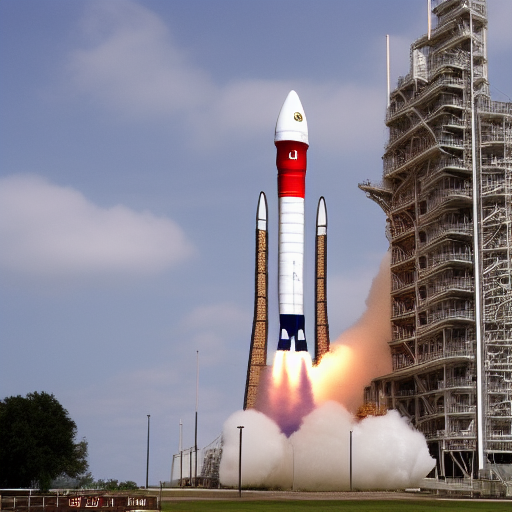

In [3]:
# the object returned is a python generator
answers = stability_api.generate(
    prompt="houston, we are a 'go' for launch!",
    init_image=None,
    seed=12345,
)

# iterating over the generator produces the api response
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            display(img)


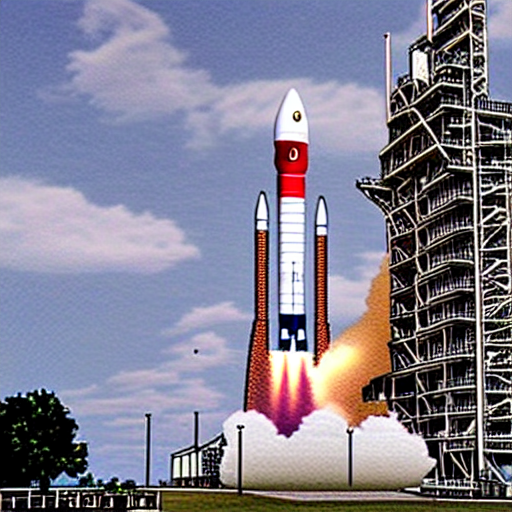

In [4]:
# the object returned is a python generator
answers = stability_api.generate(
    prompt="colored pencil sketch of a rocket launch",
    init_image=img,
    seed=12345,
    #init_mask=None
    #init=True
)#

# iterating over the generator produces the api response
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img2 = Image.open(io.BytesIO(artifact.binary))
            display(img2)
